# Simulation

Now that we have constructed our network, we can use a polarization algorithm to simulate opinion dynamics on the network. we are primarily interested in studying two distinct ways in which network stucture influences behavior: first, the time it takes to reach a stable state (i.e. stabilization; second, what that stable state is (i.e. polarization). The best method of implementing the polarization algorithm depends on the question being asked.

In order to understand stabilization time, we must know when the stable state is reached. Therefore, we wll use an event-based simualtion, counting the number of nodes that are capable of changing each iteration of the simulation and focusing on those nodes, which are collectively referred to as teh polarizing neighborhood. The simulation ends when the number of nodes in the polarizing neighborhood reaches zero. In this way, we will know exactly when a given trial reaches a stable state.

However, the event-based simulation is significantly more complex then a time-based simulation, which will terminate after a predetermined number of time steps, regardless of whether or not a stable state has been reached. A time-based simulation is more appropriate for understanding how behavior evolves over time because we can run many more simulations due to the improved processing speed. We can use what we learn about stabilization time to estimate a worst-case scenario number of time steps, which will still be faster in the time-based simulation than the best-case scenario in the event-based simulation.

Nevertheless, because previous research focused on the later, our code will begin with the time-based simulation for validation purposes. Both simulations use the same affective polarization algorithm.

The **affective polarization algorithm** takes a given network along with an $\alpha , \beta , \delta$, which respectively represent in-group love, out-group hate, and threshold parameters. Then it will pick a vertex at random and count the following:

$a = $ the number of neighbors in the same partition with opinion 0.

$b = $ the number of neighbors in the same partition with opinion 1.

$c = $ the number of neighbors in a different partition with opinion 0.

$d = $ the number of neighbors in a different partition with opinion 1.

These counts are then used in the following calculation:
$$\alpha(b-a)-\beta(d-c)$$
If this value is less than $-\delta$, it sets the opinion attribute of that vertex to 0. If it is greater than $\delta$, sets the opinion attribute to 1, and does nothing otherwise. The function `neighborhood_update` simulates opinion dynamics in a social network by selecting a random node from a given list and updating its opinion based on the influence of its neighbors. The update follows a polarization formula that weighs the influence of like-minded and opposing neighbors within and across affiliations. If the computed polarization score exceeds a given threshold ($\delta$), the node's opinion is updated accordingly. The function modifies the graph in place.

## Stabilizations Trials

**Motivation**

We are primarily interested in the system’s **stable state**, which is the point at which no further opinion changes occur. However, the **time-driven simulation** (time-sim) selects nodes at random and may select already stable nodes, making it difficult to determine whether a lack of change indicates convergence or just bad sampling.

To address this, we introduce an **event-driven simulation** (event-sim), which only applies the polarization update rule to nodes that are known to be unstable. This gives us valuable data about the system’s dynamics that we can use to estimate when the time-sim is likely to have stabilized.

**Why Not Use Event-Sim Exclusively?**

While the event-sim is more efficient in terms of convergence (fewer steps to stabilization), it is computationally expensive. Each step requires identifying all unstable nodes, which may involve scanning the entire network.

By contrast, the time-sim is much cheaper per step—especially on large graphs—but offers no built-in signal that stabilization has been reached. The goal is to use data from event-sim to define a **stabilization threshold** $t*$, at which point we can be confident the time-sim has converged.

**Definitions and Assumptions**

We define the following quantities:

- $n$: Total number of nodes in the network  
- $S_t$: Number of stable nodes at time $t$  
- $T$: Number of events required for stabilization in event-sim  
- $t^*$: Expected number of time steps to stabilization in time-sim  
- $p_t$: Probability that the time-sim selects an unstable node at time $t$

In the time-sim, where nodes are selected uniformly at random, the probability of selecting an unstable node is:
$$p_t = 1 - \frac{S_t}{n}$$

**Deriving the Stabilization Threshold**

Although one event may stabilize multiple nodes, we can estimate the average rate of stabilization as:
$$\rho = \frac{n - S_0}{T}$$

Here, $S_0$ is the number of stable nodes at the start of the simulation, and $T$ is the total number of stabilization events in the event-sim. The value $\rho$ captures the average number of nodes stabilized per event.

We introduce an **instability tolerance** $\varepsilon \in (0,1)$, which defines how close we want to be to a fully stable system. For example, $\varepsilon = 0.01$ corresponds to 99% stabilization.

The **stabilization threshold** is then given by:
$$t^* = -\frac{n}{\rho} \ln(\varepsilon)$$

This expression tells us how many time steps the time-sim should run in order to reach the desired level of convergence, based on estimates from the event-sim.

**Derivation**

Assuming stabilization progresses smoothly, we approximate the number of unstable nodes at any point in time-sim as decreasing exponentially with the number of events $E$):
$$U(E) = n - \rho E$$

Then the probability of selecting an unstable node at time $t$, when $E(t)$ events have occurred, is:
$$p_t = \frac{U(E)}{n} = \frac{n - \rho E(t)}{n}$$

Each time step contributes to event progress with probability $p_t$. So the expected change in the number of events is:
$$\frac{dE}{dt} = p_t = \frac{n - \rho E}{n}$$

This is a linear ordinary differential equation. We solve:
$$\frac{dE}{dt} = \frac{n - \rho E}{n}$$

Separate variables:
$$\frac{dE}{n - \rho E} = \frac{dt}{n}$$

Integrate both sides:
$$-\frac{1}{\rho} \ln(n - \rho E) = \frac{t}{n} + C$$

Apply the initial condition \( E(0) = 0 \):
$$C = -\frac{1}{\rho} \ln(n)$$

Substitute and simplify:
$$-\frac{1}{\rho} \ln(n - \rho E) + \frac{1}{\rho} \ln(n) = \frac{t}{n}$$
$$\ln\left( \frac{n}{n - \rho E} \right) = \frac{\rho t}{n}$$

Solving for $E(t)$:
$$E(t) = \frac{n}{\rho} \left(1 - e^{-\rho t / n} \right)$$

**Step 4: Solve for $t^*$**

We define a stabilization threshold by asking: how long until a fraction $1 - \varepsilon$ of the total stabilization events $T$ has occurred?**

So set:
$$E(t^*) = (1 - \varepsilon) T$$

Substitute into the expression for $E(t)$:
$$(1 - \varepsilon) T = \frac{n}{\rho} \left(1 - e^{-\rho t^* / n} \right)$$

Solve for $t^*$:
$$1 - \frac{(1 - \varepsilon) T \rho}{n} = e^{-\rho t^* / n}$$
$$t^* = -\frac{n}{\rho} \ln\left(1 - \frac{(1 - \varepsilon) T \rho}{n} \right)$$

Now plug in $\rho = \frac{n - S_0}{T}$. After simplification, the threshold becomes:
$$t^* = -\frac{n}{\rho} \ln(\varepsilon)$$

This is the expected number of time steps in the time-driven simulation needed to reach a state where only an $\varepsilon$-fraction of events remain.


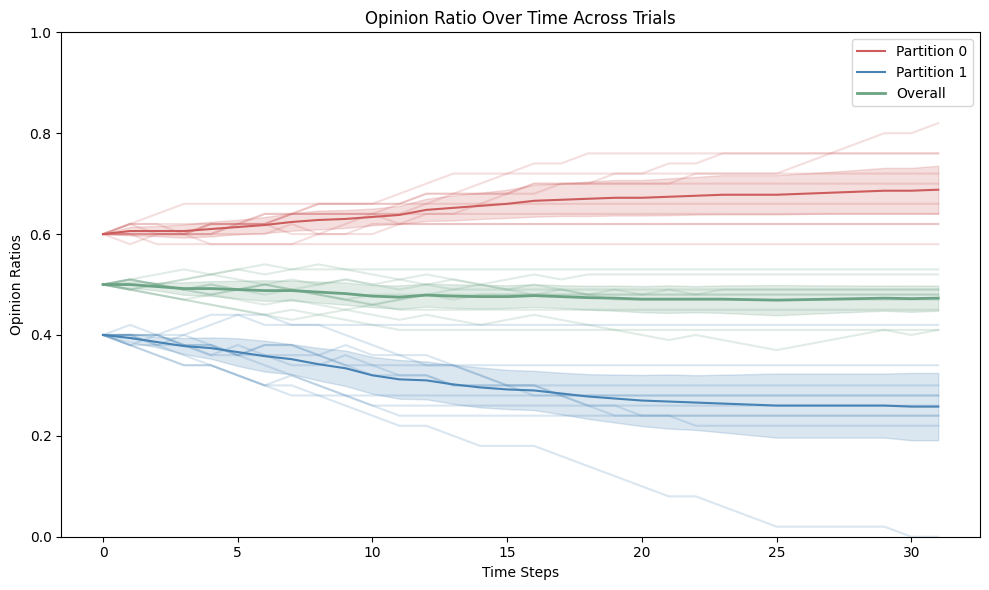

In [14]:
# --- Parameters ---
n = 100
partition_ratios = [1, 1]
opinion_ratios = [0.6, 0.4]
alpha, beta, delta = 1, 1, 2
k = 10  # number of trials

# --- Graph Template ---
G_template, _ = generate_networks(n)
subgraphs = random_subgraphs(G_template, partition_ratios)

# Assign "affiliation" manually
for i, sg in enumerate(subgraphs):
    for node in sg.nodes:
        G_template.nodes[node]["affiliation"] = i

G_template = centrality_opinions(G_template, subgraphs, [1, 1], opinion_ratios)

partitions = nx.get_node_attributes(G_template, "affiliation")
partition_ids = sorted(set(partitions.values()))
partition_sizes = {p: sum(1 for n in G_template if partitions[n] == p) for p in partition_ids}
colors = generate_colors(len(partition_ids) + 1)
partition_colors = {p: colors[i] for i, p in enumerate(partition_ids)}
overall_color = colors[len(partition_ids)]

# --- Run Trials ---
histories = []
max_len = 0

for _ in range(k):
    G, _ = generate_networks(n)
    subgraphs = random_subgraphs(G, partition_ratios)

    # Assign affiliation
    for i, sg in enumerate(subgraphs):
        for node in sg.nodes:
            G.nodes[node]["affiliation"] = i

    G = centrality_opinions(G, subgraphs, [1, 1], opinion_ratios)
    history = record_events(G, alpha=alpha, beta=beta, delta=delta)
    histories.append(history)
    max_len = max(max_len, len(history))

# --- Pad Histories to Uniform Length ---
for i in range(len(histories)):
    h = histories[i]
    if len(h) < max_len:
        last_row = h.iloc[-1:]
        pad_rows = pd.concat([last_row] * (max_len - len(h)), ignore_index=True)
        pad_rows.index = range(len(h), max_len)
        histories[i] = pd.concat([h, pad_rows])

# --- Extract Partition Data ---
partition_data = {p: [] for p in partition_ids}
overall_data = []

for h in histories:
    for p in partition_ids:
        partition_data[p].append(h[f"partition_{p}"] / partition_sizes[p])
    overall_series = sum(h[f"partition_{p}"] for p in partition_ids) / sum(partition_sizes.values())
    overall_data.append(overall_series)

# --- Plot ---
plt.figure(figsize=(10, 6))

time_index = range(max_len)
for p in partition_ids:
    runs = partition_data[p]
    for r in runs:
        plt.plot(time_index, r, color=partition_colors[p], alpha=0.2)
    df = pd.DataFrame(runs)
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    ci = 1.96 * std / np.sqrt(k)
    plt.plot(time_index, mean, color=partition_colors[p], label=f"Partition {p}")
    plt.fill_between(time_index, mean - ci, mean + ci, color=partition_colors[p], alpha=0.2)

# Overall line
for r in overall_data:
    plt.plot(time_index, r, color=overall_color, alpha=0.2)
df = pd.DataFrame(overall_data)
mean = df.mean(axis=0)
std = df.std(axis=0)
ci = 1.96 * std / np.sqrt(k)
plt.plot(time_index, mean, color=overall_color, label="Overall", linewidth=2)
plt.fill_between(time_index, mean - ci, mean + ci, color=overall_color, alpha=0.2)

plt.ylim(0, 1)
plt.xlabel("Time Steps")
plt.ylabel("Opinion Ratios")
plt.title("Opinion Ratio Over Time Across Trials")
plt.legend()
plt.tight_layout()
plt.show()


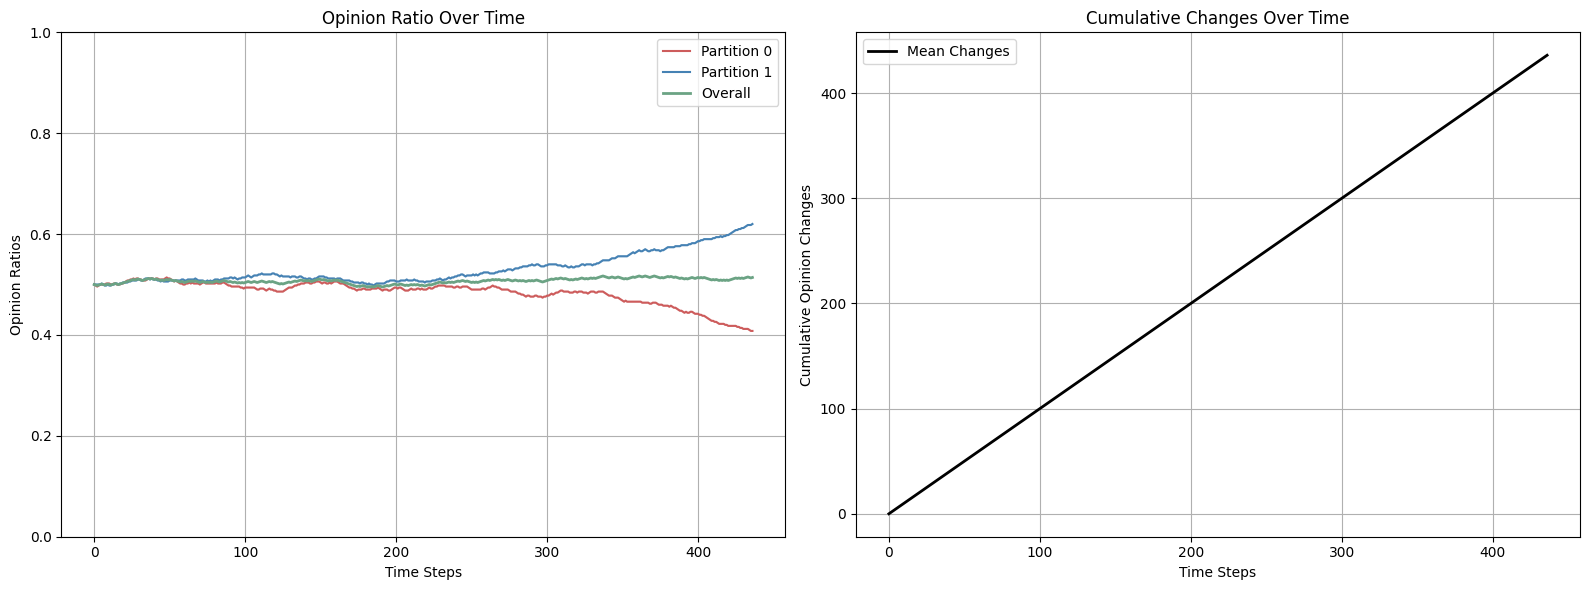

In [15]:
# --- Parameters ---
n = 1000
partition_ratios = [1, 1]
elite_opinions = [1, 0]
opinion_ratios = [0.5, 0.5]
alpha, beta, delta = 1, 1, 0
k = 1  # number of trials

# --- Graph Template ---
G_template, _ = generate_networks(n)
subgraphs = random_subgraphs(G_template, partition_ratios)

# Assign "affiliation"
for i, sg in enumerate(subgraphs):
    for node in sg.nodes:
        G_template.nodes[node]["affiliation"] = i

G_template = centrality_opinions(G_template, subgraphs, [1, 1], opinion_ratios)

partitions = nx.get_node_attributes(G_template, "affiliation")
partition_ids = sorted(set(partitions.values()))
partition_sizes = {p: sum(1 for n in G_template if partitions[n] == p) for p in partition_ids}
colors = generate_colors(len(partition_ids) + 1)
partition_colors = {p: colors[i] for i, p in enumerate(partition_ids)}
overall_color = colors[len(partition_ids)]

# --- Run Trials ---
histories = []
change_data = []
max_len = 0

for _ in range(k):
    G, _ = generate_networks(n)
    subgraphs = random_subgraphs(G, partition_ratios)
    for i, sg in enumerate(subgraphs):
        for node in sg.nodes:
            G.nodes[node]["affiliation"] = i
    G = centrality_opinions(G, subgraphs, [1, 1], opinion_ratios)

    history = record_events(G, alpha=alpha, beta=beta, delta=delta)
    histories.append(history)
    max_len = max(max_len, len(history))

    # --- Opinion change tracking ---
    cum_changes = [0]
    for t in range(1, len(history)):
        prev = history.iloc[t - 1]
        curr = history.iloc[t]
        change = sum(curr[f"partition_{p}"] != prev[f"partition_{p}"] for p in partition_ids)
        cum_changes.append(cum_changes[-1] + change)
    change_data.append(cum_changes)

# --- Pad histories and change data ---
for i in range(k):
    h = histories[i]
    if len(h) < max_len:
        last_row = h.iloc[-1:]
        pad_rows = pd.concat([last_row] * (max_len - len(h)), ignore_index=True)
        pad_rows.index = range(len(h), max_len)
        histories[i] = pd.concat([h, pad_rows])

    if len(change_data[i]) < max_len:
        last_value = change_data[i][-1]
        change_data[i].extend([last_value] * (max_len - len(change_data[i])))

# --- Extract Partition Data ---
partition_data = {p: [] for p in partition_ids}
overall_data = []

for h in histories:
    for p in partition_ids:
        partition_data[p].append(h[f"partition_{p}"] / partition_sizes[p])
    overall_series = sum(h[f"partition_{p}"] for p in partition_ids) / sum(partition_sizes.values())
    overall_data.append(overall_series)

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
time_index = range(max_len)

# Plot 1: Opinion Ratios
for p in partition_ids:
    runs = partition_data[p]
    for r in runs:
        axs[0].plot(time_index, r, color=partition_colors[p], alpha=0.2)
    df = pd.DataFrame(runs)
    mean = df.mean(axis=0)
    std = df.std(axis=0)
    ci = 1.96 * std / np.sqrt(k)
    axs[0].plot(time_index, mean, color=partition_colors[p], label=f"Partition {p}")
    axs[0].fill_between(time_index, mean - ci, mean + ci, color=partition_colors[p], alpha=0.2)

# Overall line
df = pd.DataFrame(overall_data)
mean = df.mean(axis=0)
std = df.std(axis=0)
ci = 1.96 * std / np.sqrt(k)
for r in overall_data:
    axs[0].plot(time_index, r, color=overall_color, alpha=0.2)
axs[0].plot(time_index, mean, color=overall_color, label="Overall", linewidth=2)
axs[0].fill_between(time_index, mean - ci, mean + ci, color=overall_color, alpha=0.2)

axs[0].set_ylim(0, 1)
axs[0].set_xlabel("Time Steps")
axs[0].set_ylabel("Opinion Ratios")
axs[0].set_title("Opinion Ratio Over Time")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Cumulative Opinion Changes
df = pd.DataFrame(change_data)
mean = df.mean(axis=0)
std = df.std(axis=0)
ci = 1.96 * std / np.sqrt(k)
for r in change_data:
    axs[1].plot(time_index, r, color="black", alpha=0.1)
axs[1].plot(time_index, mean, color="black", linewidth=2, label="Mean Changes")
axs[1].fill_between(time_index, mean - ci, mean + ci, color="black", alpha=0.2)

axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Cumulative Opinion Changes")
axs[1].set_title("Cumulative Changes Over Time")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


ValueError: index can't contain negative values

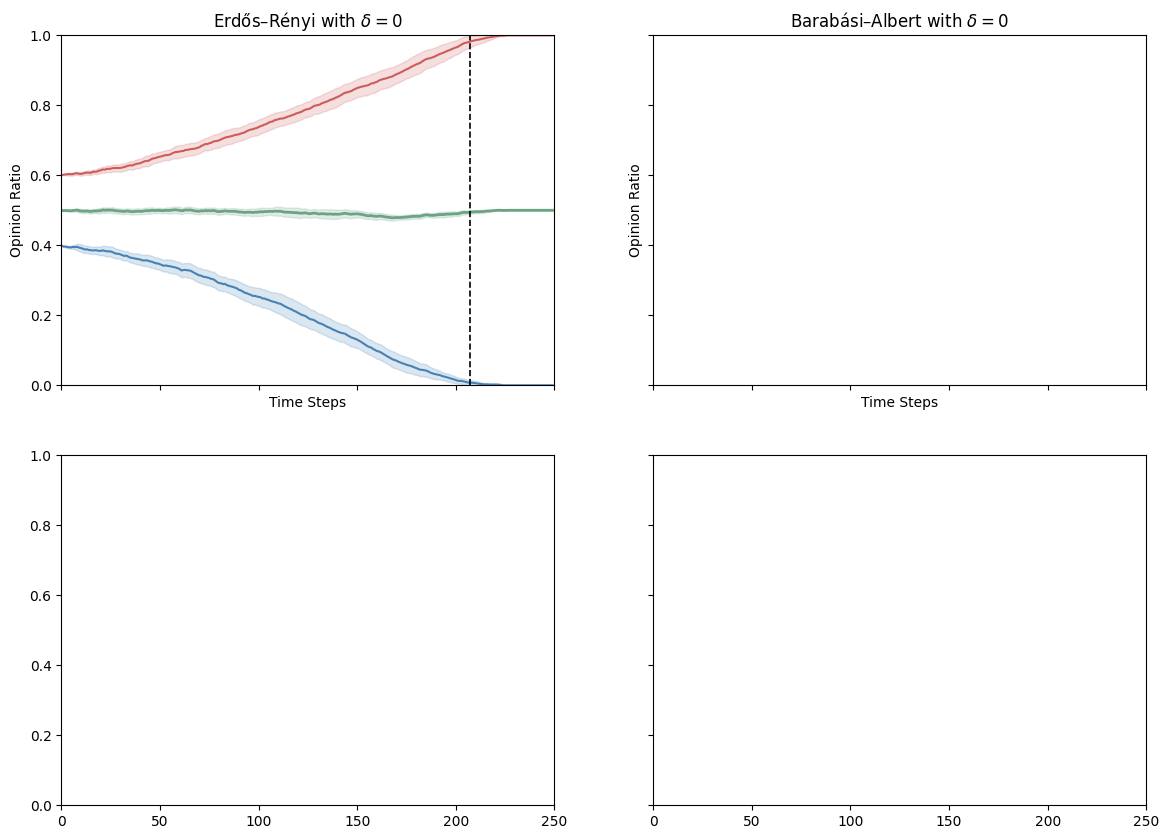

In [16]:
# --- Parameters ---
n = 400
partition_ratios = [1, 1]
opinion_ratios = [0.6, 0.4]
alpha, beta = 1, 1
k = 10  # number of trials
x_max = 250  # global max time steps for plotting
bottom_delta = 2  # <-- delta for bottom row; top row is always delta=0

# --- Setup Color Info ---
G_template, _ = generate_networks(n)
subgraphs = random_subgraphs(G_template, partition_ratios)
for i, sg in enumerate(subgraphs):
    for node in sg.nodes:
        G_template.nodes[node]["affiliation"] = i
G_template = centrality_opinions(G_template, subgraphs, [1, 1], opinion_ratios)
partitions = nx.get_node_attributes(G_template, "affiliation")
partition_ids = sorted(set(partitions.values()))
partition_sizes = {p: sum(1 for n in G_template if partitions[n] == p) for p in partition_ids}
colors = generate_colors(len(partition_ids) + 1)
partition_colors = {p: colors[i] for i, p in enumerate(partition_ids)}
overall_color = colors[len(partition_ids)]

# --- Run Experiments ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
graph_types = ["ER", "BA"]
delta_values = [0, bottom_delta]

for i, delta in enumerate(delta_values):  # top row = delta 0
    for j, gtype in enumerate(graph_types):  # left col = ER
        ax = axes[i][j]
        title = f"{gtype} Graph, delta={delta}"
        title = f"{'Erdős–Rényi' if gtype == 'ER' else 'Barabási–Albert'} with $\\delta = {delta}$"
        ax.set_title(title)
        ax.set_ylim(0, 1)
        ax.set_xlim(0, x_max)
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Opinion Ratio")

        histories = []
        stabilization_lengths = []

        for _ in range(k):
            G = generate_networks(n)[0] if gtype == "ER" else generate_networks(n, m=4)[1]
            subgraphs = random_subgraphs(G, partition_ratios)
            for idx, sg in enumerate(subgraphs):
                for node in sg.nodes:
                    G.nodes[node]["affiliation"] = idx
            G = centrality_opinions(G, subgraphs, [1, 1], opinion_ratios)
            history = record_events(G, alpha=alpha, beta=beta, delta=delta)
            histories.append(history)
            stabilization_lengths.append(len(history))

        # Extract data
        partition_data = {p: [] for p in partition_ids}
        overall_data = []
        for h in histories:
            for p in partition_ids:
                partition_data[p].append((h[f"partition_{p}"] / partition_sizes[p]).values)
            overall_series = sum(h[f"partition_{p}"] for p in partition_ids) / sum(partition_sizes.values())
            overall_data.append(overall_series.values)

        time_index = np.arange(x_max)

        for p in partition_ids:
            runs = partition_data[p]
            df = pd.DataFrame([np.pad(r, (0, x_max - len(r)), constant_values=r[-1]) for r in runs])
            mean = df.mean(axis=0)
            std = df.std(axis=0)
            ci = 1.96 * std / np.sqrt(k)
            ax.plot(time_index, mean, color=partition_colors[p], label=f"Partition {p}")
            ax.fill_between(time_index, mean - ci, mean + ci, color=partition_colors[p], alpha=0.2)

        df = pd.DataFrame([np.pad(r, (0, x_max - len(r)), constant_values=r[-1]) for r in overall_data])
        mean = df.mean(axis=0)
        std = df.std(axis=0)
        ci = 1.96 * std / np.sqrt(k)
        ax.plot(time_index, mean, color=overall_color, label="Overall", linewidth=2)
        ax.fill_between(time_index, mean - ci, mean + ci, color=overall_color, alpha=0.2)

        avg_stab_time = int(np.mean(stabilization_lengths))
        ax.axvline(avg_stab_time, color="black", linestyle="--", linewidth=1.2)

# --- Shared Legend ---
handles, labels = axes[0][0].get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mean Stabilization Time'))
labels.append('Mean Stabilization Time')
fig.legend(handles, labels, loc='upper center', ncol=5, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
# --- Parameters ---
n = 400
partition_ratios = [1, 1]
alpha, beta, delta = 1, 1, 2
k = 10
x_max = 200

# --- Setup Color Info ---
G_template, _ = generate_networks(n)
subgraphs = random_subgraphs(G_template, partition_ratios)
for i, sg in enumerate(subgraphs):
    for node in sg.nodes:
        G_template.nodes[node]["affiliation"] = i
G_template = centrality_opinions(G_template, subgraphs, [0, 1], [0.25, 0.25])
partitions = nx.get_node_attributes(G_template, "affiliation")
partition_ids = sorted(set(partitions.values()))
partition_sizes = {p: sum(1 for n in G_template if partitions[n] == p) for p in partition_ids}
colors = generate_colors(len(partition_ids) + 1)
partition_colors = {p: colors[i] for i, p in enumerate(partition_ids)}
overall_color = colors[len(partition_ids)]

# --- Run Experiments ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
graph_types = ["ER", "BA"]
assignment_modes = ["random", "centrality"]

for i, mode in enumerate(assignment_modes):  # top row = random, bottom = centrality
    for j, gtype in enumerate(graph_types):  # left col = ER
        ax = axes[i][j]
        title = f"{'Erdős–Rényi' if gtype == 'ER' else 'Barabási–Albert'} with {mode.title()} Assignment"
        ax.set_title(title)
        ax.set_ylim(0, 1)
        ax.set_xlim(0, x_max)
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Opinion Ratio")

        histories = []
        stabilization_lengths = []

        for _ in range(k):
            G = generate_networks(n)[0] if gtype == "ER" else generate_networks(n, m=4)[1]
            subgraphs = random_subgraphs(G, partition_ratios)
            for idx, sg in enumerate(subgraphs):
                for node in sg.nodes:
                    G.nodes[node]["affiliation"] = idx

            if mode == "centrality":
                G = centrality_opinions(G, subgraphs, [0, 1], [0.45, 0.45])
            else:
                G = random_opinions(G, subgraphs, [0.55, 0.45])

            history = record_events(G, alpha=alpha, beta=beta, delta=delta)
            histories.append(history)
            stabilization_lengths.append(len(history))

        # Extract data
        partition_data = {p: [] for p in partition_ids}
        overall_data = []
        for h in histories:
            for p in partition_ids:
                partition_data[p].append((h[f"partition_{p}"] / partition_sizes[p]).values)
            overall_series = sum(h[f"partition_{p}"] for p in partition_ids) / sum(partition_sizes.values())
            overall_data.append(overall_series.values)

        time_index = np.arange(x_max)

        for p in partition_ids:
            runs = partition_data[p]
            df = pd.DataFrame([np.pad(r, (0, x_max - len(r)), constant_values=r[-1]) for r in runs])
            mean = df.mean(axis=0)
            std = df.std(axis=0)
            ci = 1.96 * std / np.sqrt(k)
            ax.plot(time_index, mean, color=partition_colors[p], label=f"Partition {p}")
            ax.fill_between(time_index, mean - ci, mean + ci, color=partition_colors[p], alpha=0.2)

        df = pd.DataFrame([np.pad(r, (0, x_max - len(r)), constant_values=r[-1]) for r in overall_data])
        mean = df.mean(axis=0)
        std = df.std(axis=0)
        ci = 1.96 * std / np.sqrt(k)
        ax.plot(time_index, mean, color=overall_color, label="Overall", linewidth=2)
        ax.fill_between(time_index, mean - ci, mean + ci, color=overall_color, alpha=0.2)

        avg_stab_time = int(np.mean(stabilization_lengths))
        ax.axvline(avg_stab_time, color="black", linestyle="--", linewidth=1.2)

# --- Shared Legend ---
handles, labels = axes[0][0].get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='black', linestyle='--', label='Mean Stabilization Time'))
labels.append('Mean Stabilization Time')
fig.legend(handles, labels, loc='upper center', ncol=5, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Generate Data for DB

In [ ]:
# --- Define Parameter Grids ---
n_list = [800, 1000]
m_list = [4]
k = 4  # Trials per condition

partition_ratios_list = [[1, 1], [1, 2], [2,1]]
opinion_ratios_list   = [[0.5, 0.5], [0.6, 0.4], [0.4, 0.6]]
elite_opinions_list   = [[1, 1], [1, 0], [0, 1]]
alpha_list = [0.8, 1.0, 1.2]
beta_list  = [0.8, 1.0, 1.2]
delta_list = [0, 2]

# --- Build Full Parameter Grid ---
param_grid = list(itertools.product(
    n_list,
    m_list,
    partition_ratios_list,
    opinion_ratios_list,
    elite_opinions_list,
    alpha_list,
    beta_list,
    delta_list
))

# --- Calculate Trial Count ---
total_combinations = len(param_grid)
total_trials = total_combinations * k

# --- Run All Trials with Global Progress Bar ---
with tqdm(total=total_trials, desc="Running stabilization trials") as pbar:
    for n, m, partition_ratios, opinion_ratios, elite_opinions, alpha, beta, delta in param_grid:
        for _ in range(k):
            record_stabilization_trials(
                n=n,
                m=m,
                k=1,  # Single trial per call, since we're looping k times
                partition_ratios=partition_ratios,
                opinion_ratios=opinion_ratios,
                elite_opinions=elite_opinions,
                alpha=alpha,
                beta=beta,
                delta=delta
            )
            pbar.update(1)


Compute p-values for Stabilization Time

In [ ]:
filters = {
    "graph_type": "BA",        # "ER" or "BA"
    "opinion_type": 'centrality',      # "random" or "centrality"
    "order": None,
    "size": None,
    "imbalance_ratio": None,
    "opinion_ratio1": None,
    "opinion_ratio2": None,
    "alpha": None,
    "beta": None,
    "delta": None,
    "gamma": None
}

# --- Extract and remove special-case filters ---
graph_type = filters.pop("graph_type", None)
opinion_type = filters.pop("opinion_type", None)

# --- Remove unused filters (i.e., those still set to None) ---
active_filters = {k: v for k, v in filters.items() if v is not None}

# --- Run Correlation Analysis ---
pval_table = analyze_trial_correlations(graph_type=graph_type, opinion_type=opinion_type, **active_filters)

# --- Display Results ---
print("P-value matrix (input vs. outcome):\n")
display(pval_table.round(4))


In [ ]:
import pandas as pd
import sqlite3
import statsmodels.formula.api as smf

def regression_on_rho():
    conn = sqlite3.connect("Stabilization Trials.db")
    df = pd.read_sql_query("SELECT * FROM trial_results", conn)
    conn.close()

    df = df.dropna()

    results = {}

    for gtype in ["ER", "BA"]:
        for otype in ["random", "centrality"]:
            subset = df[(df["graph_type"] == gtype) & (df["opinion_type"] == otype)]
            if subset.empty:
                continue

            predictors = ["delta"]
            if gtype == "BA":
                predictors.append("gamma")

            formula = "rho ~ " + " + ".join(predictors)

            model = smf.ols(formula=formula, data=subset).fit()
            label = f"{gtype}_{otype}"
            results[label] = {
                "model": model,
                "coefficients": model.params.rename(label)
            }

    return results


In [ ]:
results = regression_on_rho()

# Combine coefficients into one table
coef_table = pd.concat([v["coefficients"] for v in results.values()], axis=1)

pd.set_option('display.float_format', '{:.2e}'.format)
display(coef_table)


In [ ]:
import pandas as pd
import sqlite3
import statsmodels.formula.api as smf

def regression_on_rho_by_categorical_factors():
    conn = sqlite3.connect("Stabilization Trials.db")
    df = pd.read_sql_query("SELECT * FROM trial_results", conn)
    conn.close()

    df = df.dropna()

    # Set reference categories
    df["graph_type"] = df["graph_type"].astype("category")
    df["graph_type"] = df["graph_type"].cat.reorder_categories(["ER", "BA"], ordered=False)

    df["opinion_type"] = df["opinion_type"].astype("category")
    df["opinion_type"] = df["opinion_type"].cat.reorder_categories(["random", "centrality"], ordered=False)

    results = {}

    # Bivariate model: only opinion_type (all graph types)
    results["bivariate_opinion_type"] = smf.ols("rho ~ opinion_type", data=df).fit()

    # Multivariate model: main effects + interaction
    results["multivariate_with_interaction"] = smf.ols("rho ~ opinion_type * graph_type", data=df).fit()

    # Bivariate test restricted to BA networks only
    df_ba = df[df["graph_type"] == "BA"]
    results["bivariate_within_BA"] = smf.ols("rho ~ opinion_type", data=df_ba).fit()

    return results

In [ ]:
import pandas as pd
import sqlite3
import statsmodels.formula.api as smf

# Load regression results
results = regression_on_rho_by_categorical_factors()

# Select models
model_biv = results["bivariate_within_BA"]
model_mult = results["multivariate_with_interaction"]

# Create clean results table
def clean_regression_table(model):
    return pd.DataFrame({
        "Coefficient": model.params,
        "Std. Error": model.bse,
        "t-Statistic": model.tvalues,
        "P-Value": model.pvalues,
        "CI Lower 95%": model.conf_int()[0],
        "CI Upper 95%": model.conf_int()[1]
    })

# Generate both tables
bivariate_table = clean_regression_table(model_biv)
multivariate_table = clean_regression_table(model_mult)

# Display both
print("📊 Bivariate Regression (BA Only)")
display(bivariate_table)

print("\n📊 Multivariate Regression (All Data with Interaction)")
display(multivariate_table)

In [ ]:
import matplotlib.pyplot as plt

# Use the multivariate results table you built earlier
coefs = multivariate_table.copy()
coefs = coefs.drop(index='Intercept')  # Remove intercept for clarity

# Plot
plt.figure(figsize=(8, 4))
plt.errorbar(
    x=coefs["Coefficient"],
    y=coefs.index,
    xerr=coefs["CI Upper 95%"] - coefs["Coefficient"],
    fmt='o',
    capsize=5,
    color='black'
)

# Add a vertical line at 0 (null effect)
plt.axvline(x=0, color='red', linestyle='--')
plt.title("Regression Coefficients with 95% CI")
plt.xlabel("Estimated Effect on Stabilization Rate (ρ)")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

In [ ]:
import sqlite3
import pandas as pd

def overall_mean_rho():
    conn = sqlite3.connect("Stabilization Trials.db")
    df = pd.read_sql_query("SELECT rho FROM trial_results", conn)
    conn.close()

    mean_rho = df["rho"].mean()
    return mean_rho

# Run and display
mean_rho = overall_mean_rho()
print(f"Overall mean rho: {mean_rho:.4f}")


In [ ]:
import pandas as pd
import sqlite3

def rho_summary_all_n():
    """
    Returns a 2x2 DataFrame of mean ± stddev of rho for all trials (regardless of n).
    Rows = opinion type (random, centrality)
    Columns = graph type (ER, BA)
    """
    conn = sqlite3.connect("Stabilization Trials.db")
    df = pd.read_sql_query("SELECT * FROM trial_results", conn)
    conn.close()

    df = df.dropna()
    df["S0"] = df["order"] - df["C0"]

    summary = pd.DataFrame(index=["random", "centrality"], columns=["ER", "BA"])

    for otype in summary.index:
        for gtype in summary.columns:
            subset = df[(df["graph_type"] == gtype) & (df["opinion_type"] == otype)]
            if subset.empty:
                summary.loc[otype, gtype] = "-"
                continue
            mean = subset["rho"].mean()
            std = subset["rho"].std()
            summary.loc[otype, gtype] = f"{mean:.4f} ± {std:.4f}"

    return summary

# Run locally
summary_table = rho_summary_all_n()
print("\nMean ± StdDev of rho (all n):")
print(summary_table.to_string())


In [ ]:
import pandas as pd
import sqlite3
import statsmodels.api as sm
from statsmodels.formula.api import ols

def anova_on_rho():
    # Load data
    conn = sqlite3.connect("Stabilization Trials.db")
    df = pd.read_sql_query("SELECT * FROM trial_results", conn)
    conn.close()

    df = df.dropna()

    # Fit ANOVA model
    model = ols("rho ~ C(graph_type) * C(opinion_type)", data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)

    # Format small p-values in scientific notation
    pd.set_option('display.float_format', '{:.2e}'.format)

    return anova_table

# Run
anova_results = anova_on_rho()
print("\nANOVA Results for rho ~ graph_type * opinion_type:")
print(anova_results)


In [ ]:
import numpy as np
import pandas as pd

def compute_t_star_table(epsilon, n=1000):
    # Mean rho values from the LaTeX table
    mean_rho = {
        ("random", "ER"): 0.7653,
        ("random", "BA"): 0.7003,
        ("centrality", "ER"): 0.6687,
        ("centrality", "BA"): 0.7394,
    }

    # Compute t* using the formula: -(n / rho) * ln(epsilon)
    t_star = {
        (otype, gtype): - (n / rho) * np.log(epsilon)
        for (otype, gtype), rho in mean_rho.items()
    }

    # Format as a 2x2 DataFrame
    df = pd.DataFrame({
        "ER": {
            "random": t_star[("random", "ER")],
            "centrality": t_star[("centrality", "ER")]
        },
        "BA": {
            "random": t_star[("random", "BA")],
            "centrality": t_star[("centrality", "BA")]
        }
    })

    return df.round(2)

# Example usage
epsilon = 0.05
t_star_table = compute_t_star_table(epsilon)
print(f"t* values for epsilon = {epsilon}:\n")
print(t_star_table)


## Polarization Trials

In [ ]:
# --- Parameters ---
n = 1000
partition_ratios = [1, 1]
elite_opinions = [1, 0]
opinion_ratios = [0.5, 0.5]
alpha, beta, delta = 1, 1, 0
t = 4000  # number of time steps per trial
k = 1    # number of trials

# --- Preallocate Storage ---
partition_ids = list(range(len(partition_ratios)))
partition_data = {p: np.zeros((k, t + 1)) for p in partition_ids}
overall_data = np.zeros((k, t + 1))
change_data = np.zeros((k, t + 1))
colors = generate_colors(len(partition_ids) + 1)
partition_colors = {p: colors[i] for i, p in enumerate(partition_ids)}
overall_color = colors[len(partition_ids)]

# --- Run Trials ---
for run_id in range(k):
    G, _ = generate_networks(n)
    subgraphs = random_subgraphs(G, partition_ratios)

    # --- FIX: Manually assign affiliation since random_subgraphs doesn't do it ---
    for i, sg in enumerate(subgraphs):
        for node in sg.nodes:
            G.nodes[node]["affiliation"] = i

    G = centrality_opinions(G, subgraphs, elite_opinions, opinion_ratios)
    partitions = nx.get_node_attributes(G, "affiliation")
    partition_sizes = {p: sum(1 for n in G if partitions[n] == p) for p in partition_ids}

    for step in range(t + 1):
        opinions_before = nx.get_node_attributes(G, "opinion")

        counts = Counter((partitions[n], opinions_before[n]) for n in G.nodes)
        for p in partition_ids:
            partition_data[p][run_id, step] = counts.get((p, 1), 0) / partition_sizes[p]

        overall_data[run_id, step] = sum(counts.get((p, 1), 0) for p in partition_ids) / sum(partition_sizes.values())

        if step < t:
            changed = neighborhood_update(G, list(G.nodes), alpha, beta, delta)
            opinions_after = nx.get_node_attributes(G, "opinion")
            change_count = sum(opinions_before[n] != opinions_after[n] for n in G.nodes)
            change_data[run_id, step + 1] = change_data[run_id, step] + change_count
        else:
            change_data[run_id, step] = change_data[run_id, step - 1]

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Opinion Ratios
for p in partition_ids:
    values = partition_data[p]
    for i in range(k):
        axs[0].plot(range(t + 1), values[i], color=partition_colors[p], alpha=0.2)
    mean = values.mean(axis=0)
    std = values.std(axis=0)
    ci = 1.96 * std / np.sqrt(k)
    axs[0].plot(range(t + 1), mean, color=partition_colors[p], label=f"Partition {p}")
    axs[0].fill_between(range(t + 1), mean - ci, mean + ci, color=partition_colors[p], alpha=0.2)

# Overall line
for i in range(k):
    axs[0].plot(range(t + 1), overall_data[i], color=overall_color, alpha=0.2)
mean = overall_data.mean(axis=0)
std = overall_data.std(axis=0)
ci = 1.96 * std / np.sqrt(k)
axs[0].plot(range(t + 1), mean, color=overall_color, label="Overall", linewidth=2)
axs[0].fill_between(range(t + 1), mean - ci, mean + ci, color=overall_color, alpha=0.2)

axs[0].set_ylim(0, 1)
axs[0].set_xlabel("Time Steps")
axs[0].set_ylabel("Opinion Ratios")
axs[0].set_title("Opinion Ratio Over Time Across Trials")
axs[0].legend()
axs[0].grid(True)

# Plot 2: Cumulative Number of Opinion Changes
for i in range(k):
    axs[1].plot(range(t + 1), change_data[i], color='black', alpha=0.1)

mean = change_data.mean(axis=0)
std = change_data.std(axis=0)
ci = 1.96 * std / np.sqrt(k)
axs[1].plot(range(t + 1), mean, color='black', label="Mean Changes", linewidth=2)
axs[1].fill_between(range(t + 1), mean - ci, mean + ci, color='black', alpha=0.2)

axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Cumulative Opinion Changes")
axs[1].set_title("Cumulative Opinion Changes Over Time")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# --- Parameters ---
n = 400
partition_ratios = [1, 1]
elite_opinions = [1, 0]
opinion_ratios = [0.5, 0.5]
alpha, beta, delta = 1, 1, 0
k = 10
t = 2000  # number of time steps per trial

# --- Setup Color Info ---
G_template, _ = generate_networks(n)
subgraphs = random_subgraphs(G_template, partition_ratios)
for i, sg in enumerate(subgraphs):
    for node in sg.nodes:
        G_template.nodes[node]["affiliation"] = i
G_template = centrality_opinions(G_template, subgraphs, elite_opinions, opinion_ratios)
partitions = nx.get_node_attributes(G_template, "affiliation")
partition_ids = sorted(set(partitions.values()))
partition_sizes = {p: sum(1 for n in G_template if partitions[n] == p) for p in partition_ids}
colors = generate_colors(len(partition_ids) + 1)
partition_colors = {p: colors[i] for i, p in enumerate(partition_ids)}
overall_color = colors[len(partition_ids)]

# --- Figure Setup ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
graph_types = ["ER", "BA"]
opinion_types = ["random", "centrality"]

for row, opinion_type in enumerate(opinion_types):  # top: random, bottom: centrality
    for col, gtype in enumerate(graph_types):       # left: ER, right: BA
        ax = axes[row][col]
        title = f"{'Erdős–Rényi' if gtype == 'ER' else 'Barabási–Albert'} with {opinion_type.capitalize()} Opinions"
        ax.set_title(title)
        ax.set_ylim(0, 1)
        ax.set_xlabel("Time Steps")
        ax.set_ylabel("Opinion Ratio")

        # Storage for trial histories
        partition_agg = {p: [] for p in partition_ids}
        overall_agg = []

        for _ in range(k):
            G = generate_networks(n)[0] if gtype == "ER" else generate_networks(n, m=4)[1]
            subgraphs = random_subgraphs(G, partition_ratios)
            for i, sg in enumerate(subgraphs):
                for node in sg.nodes:
                    G.nodes[node]["affiliation"] = i

            if opinion_type == "random":
                G = random_opinions(G, subgraphs, opinion_ratios)
            else:
                G = centrality_opinions(G, subgraphs, elite_opinions, opinion_ratios)

            partitions = nx.get_node_attributes(G, "affiliation")
            sizes = {p: sum(1 for n in G if partitions[n] == p) for p in partition_ids}

            data = {p: [] for p in partition_ids}
            overall = []

            for step in range(t + 1):
                opinions = nx.get_node_attributes(G, "opinion")
                counts = Counter((partitions[n], opinions[n]) for n in G.nodes)
                for p in partition_ids:
                    data[p].append(counts.get((p, 1), 0) / sizes[p])
                overall.append(sum(counts.get((p, 1), 0) for p in partition_ids) / sum(sizes.values()))

                if step < t:
                    neighborhood_update(G, list(G.nodes), alpha, beta, delta)

            for p in partition_ids:
                partition_agg[p].append(np.array(data[p]))
            overall_agg.append(np.array(overall))

        time_index = np.arange(t + 1)
        for p in partition_ids:
            runs = partition_agg[p]
            for r in runs:
                ax.plot(time_index, r, color=partition_colors[p], alpha=0.2)
            df = pd.DataFrame(runs)
            mean = df.mean()
            std = df.std()
            ci = 1.96 * std / np.sqrt(k)
            ax.plot(time_index, mean, color=partition_colors[p], label=f"Partition {p}")
            ax.fill_between(time_index, mean - ci, mean + ci, color=partition_colors[p], alpha=0.2)

        df = pd.DataFrame(overall_agg)
        mean = df.mean()
        std = df.std()
        ci = 1.96 * std / np.sqrt(k)
        ax.plot(time_index, mean, color=overall_color, label="Overall", linewidth=2)
        ax.fill_between(time_index, mean - ci, mean + ci, color=overall_color, alpha=0.2)

        # Add legend only to top-left plot
        if row == 0 and col == 0:
            ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# --- Define Parameter Grids ---
n_list = [400]
m_list = [3]
k = 1 # Trials per condition
t = 5000 # Time steps per trial

partition_ratios_list = [[1, 1]]
opinion_ratios_list   = [[0.5, 0.5]]
elite_opinions_list   = [[1, 1]]
alpha_list = [1]
beta_list  = [1]
delta_list = [0]

# Calculate total number of parameter combinations
total_combinations = len(n_list) * len(m_list) * len(partition_ratios_list) * len(opinion_ratios_list) * len(elite_opinions_list) * len(alpha_list) * len(beta_list) * len(delta_list)

# Define the parameter grids
param_grid = itertools.product(
    n_list,
    m_list,
    partition_ratios_list,
    opinion_ratios_list,
    elite_opinions_list,
    alpha_list,
    beta_list,
    delta_list
)

# Single progress bar for the entire batch
for n, m, partition_ratios, opinion_ratios, elite_opinions, alpha, beta, delta in tqdm(param_grid, total=total_combinations, desc="Running trials"):
    # Call the function for each combination of parameters
    record_polarization_trials(
        n=n,
        m=m,
        k=k,
        partition_ratios=partition_ratios,
        opinion_ratios=opinion_ratios,
        elite_opinions=elite_opinions,
        alpha=alpha,
        beta=beta,
        delta=delta,
        t=t
    )

In [ ]:
# --- Define Filter Template (Edit as Needed) ---
filters = {
    "graph_type": None,        # "ER" or "BA"
    "opinion_type": None,      # "random" or "centrality"
    "order": None,             # number of nodes
    "size": None,              # number of edges
    "imbalance_ratio": None,   # e.g., 2.0
    "opinion_ratio1": None,    # e.g., 0.6
    "opinion_ratio2": None,    # e.g., 0.4
    "alpha": None,             # opinion dynamics parameters
    "beta": None,
    "delta": None,
    "gamma": None,             # only applies if graph_type == "BA"
    "initial_intergroup_diff": None  # abs(opinion_ratio1 - opinion_ratio2)
}

# --- Remove unused filters (i.e., those still set to None) ---
active_filters = {k: v for k, v in filters.items() if v is not None}

# --- Run Correlation Analysis (returns two tables) ---
pvals, coefs = analyze_polarization_correlations(**active_filters)

# --- Force scientific notation for all floats ---
pd.set_option('display.float_format', '{:.2e}'.format)

# --- Display Results ---
print("P-value matrix (input vs. outcome):\n")
display(pvals)

print("\nCoefficient matrix (input vs. outcome):\n")
display(coefs)

In [ ]:
# --- Define Filter Template (Edit as Needed) ---
filters = {
    "graph_type": None,        # "ER" or "BA"
    "opinion_type": None,      # "random" or "centrality"
    "order": None,             # number of nodes
    "size": None,              # number of edges
    "imbalance_ratio": None,   # e.g., 2.0
    "opinion_ratio1": None,    # e.g., 0.6
    "opinion_ratio2": None,    # e.g., 0.4
    "alpha": None,             # opinion dynamics parameters
    "beta": None,
    "delta": None,
    "gamma": None,             # only applies if graph_type == "BA"
    "initial_intergroup_diff": None  # abs(opinion_ratio1 - opinion_ratio2)
}

# --- Remove unused filters (i.e., those still set to None) ---
active_filters = {k: v for k, v in filters.items() if v is not None}

# --- Run analysis ---
pvals, coefs = analyze_polarization_correlations(**active_filters)

# --- Build formatted tables ---
fmt_pvals = pvals.map(
    lambda v: 1 if pd.notnull(v) and v < 0.05 else 0
)

fmt_coefs = coefs.map(
    lambda v: "+" if pd.notnull(v) and v > 0 
              else "-" if pd.notnull(v) and v < 0 
              else ""
)

# --- Display ---
print("Significance (p < 0.05):\n")
display(fmt_pvals)

print("\nDirection of effect (+/–):\n")
display(fmt_coefs)

In [ ]:
# --- Define and filter as before ---
filters = {
    "graph_type": None,        # "ER" or "BA"
    "opinion_type": None,      # "random" or "centrality"
    "order": None,             # number of nodes
    "size": None,              # number of edges
    "imbalance_ratio": None,   # e.g., 2.0
    "opinion_ratio1": None,    # e.g., 0.6
    "opinion_ratio2": None,    # e.g., 0.4
    "alpha": None,             # opinion dynamics parameters
    "beta": None,
    "delta": None,
    "gamma": None,             # only applies if graph_type == "BA"
    "initial_intergroup_diff": None  # abs(opinion_ratio1 - opinion_ratio2)
}
active_filters = {k: v for k, v in filters.items() if v is not None}

# --- Run analysis ---
pvals, coefs = analyze_polarization_correlations(**active_filters)

# --- Build combined table ---
combined = pd.DataFrame("", index=pvals.index, columns=pvals.columns)
# + if coef>0 AND p<0.05; - if coef<0 AND p<0.05; else blank
mask_pos = (pvals < 0.05) & (coefs > 0)
mask_neg = (pvals < 0.05) & (coefs < 0)
combined[mask_pos] = "+"
combined[mask_neg] = "-"

# --- Display ---
print("Direction & significance (+: positive & p<0.05; -: negative & p<0.05)\n")
display(combined)